In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster

sns.set(rc={'figure.figsize':(12,8)})

In [13]:
df = pd.read_excel("Case Prediction Data2.xlsx")

In [11]:
df_comp = df
df_comp.head()

,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title,Date
0,204977,Efile Acceptance,2017-01-02,2017-01-03,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have no...,Compliance,Returns / Reports,NaN,NaN,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor,2017-01-02
1,204979,Oregon STAT help: Previous Case 203787 Client ...,2017-01-02,2017-01-04,Web,High,Tax Preparation,Question / How To,Silver,Oregon STAT help: Previous Case 203787 Client ...,Provision,State,NaN,NaN,US.OR,Customer no longer needs assistance,NaN,NaN,2017-01-02
2,204980,Data map incorrectly pulling in values,2017-01-02,2017-01-03,Web,Medium,Tax Preparation,Question / How To,Silver,Corptax Office Import - Credit Account imports...,Office - Excel Add-In,Import / Export,NaN,NaN,US,Answer exists KB,041414821333274,Corptax® Office - How to place an IF formula i...,2017-01-02
3,204981,The New Corptax Connect Website is not properl...,2017-01-02,2017-01-03,Web,High,Tax Preparation,Problem / Error,Silver,Searches can't be performed on the new system....,Websites,Connections (https://connect.corptax.com),Error Message,NaN,NaN,Answer exists KB,161216104028927,Connections Error - Uh Oh something went wron...,2017-01-02
4,204986,LD400 is not reflecting a temporary adjustment,2017-01-03,2017-01-05,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,Returns / Reports,NaN,NaN,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and...,2017-01-03


In [15]:
#dfc = df[df.Product == "Compliance"]
# df_comp['Date Created'] = df_comp['Date Created'].dt.date
# df_comp['Date Closed'] = df_comp['Date Closed'].dt.date
df_comp['Date'] = pd.to_datetime(df_comp['Date Created'], errors='coerce')
dfc = df_comp

In [16]:
# Adding a new column which will have the number of tickets per day
newdf = dfc[["Date","Case Number"]]
newdf.drop_duplicates(inplace=True)
newdf['Date'] = pd.to_datetime(newdf['Date'])
newdf = pd.DataFrame(newdf.groupby([newdf["Date"].dt.date]).count()["Case Number"])
newdf = newdf.reset_index()
newdf.index = newdf.Date
newdf['Date'] = pd.to_datetime(newdf['Date'], errors='coerce')
newdf = newdf.asfreq('D')
newdf

,Date,Case Number
Date,,
2017-01-02,2017-01-02,4.0
2017-01-03,2017-01-03,84.0
2017-01-04,2017-01-04,113.0
2017-01-05,2017-01-05,106.0
2017-01-06,2017-01-06,87.0
...,...,...
2022-08-11,2022-08-11,110.0
2022-08-12,2022-08-12,99.0
2022-08-13,2022-08-13,16.0


In [17]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2052 entries, 2017-01-02 to 2022-08-15
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2023 non-null   datetime64[ns]
 1   Case Number  2023 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 48.1 KB


In [18]:
f = Forecaster(y=newdf['Case Number'],current_dates=newdf.index)
f

Forecaster(
    DateStartActuals=2017-01-31T00:00:00.000000000
    DateEndActuals=2022-08-15T00:00:00.000000000
    Freq=D
    N_actuals=2023
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

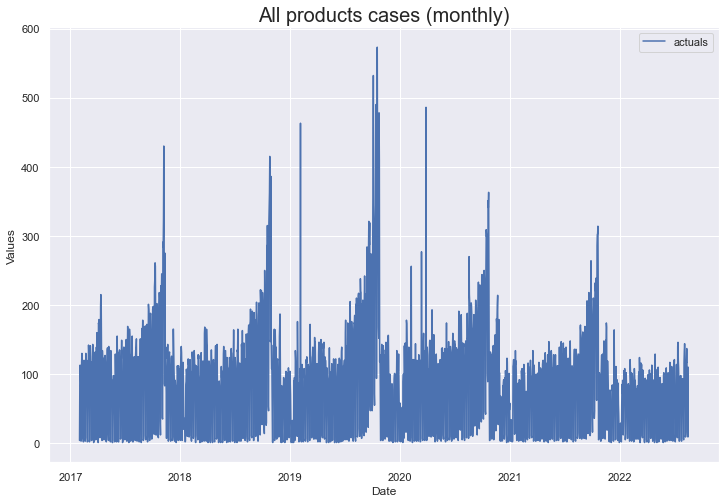

In [19]:
f.plot()
plt.title('All products cases (monthly)',size=20)
plt.show()

In [20]:
f.generate_future_dates(150)
f.set_test_length(.3)
f.set_validation_length(300)
f

Forecaster(
    DateStartActuals=2017-01-31T00:00:00.000000000
    DateEndActuals=2022-08-15T00:00:00.000000000
    Freq=D
    N_actuals=2023
    ForecastLength=150
    Xvars=[]
    Differenced=0
    TestLength=606
    ValidationLength=300
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [21]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -4.53
the p-value is 0.0002
the series is stationary
----------------------------------------------------------------------------------------------------


In [22]:
f.set_estimator('hwes')
f.manual_forecast(call_me='naive')

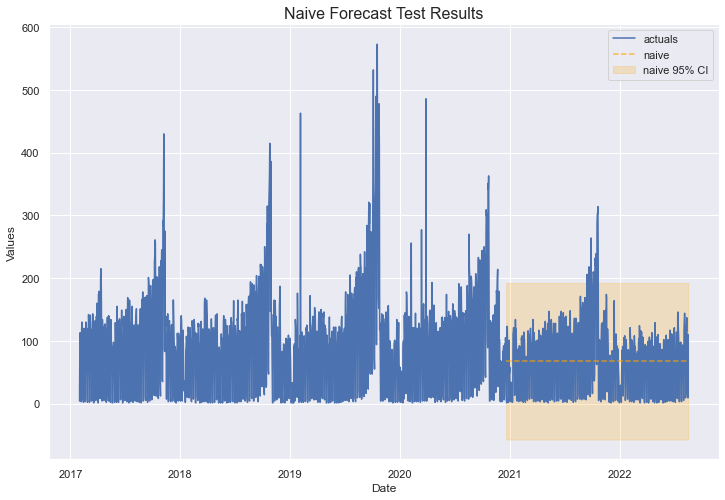

In [23]:
f.plot_test_set(ci=True)
plt.title('Naive Forecast Test Results',size=16)
plt.show()

# Trend

In [24]:
f.manual_forecast(trend='add',call_me='trend')

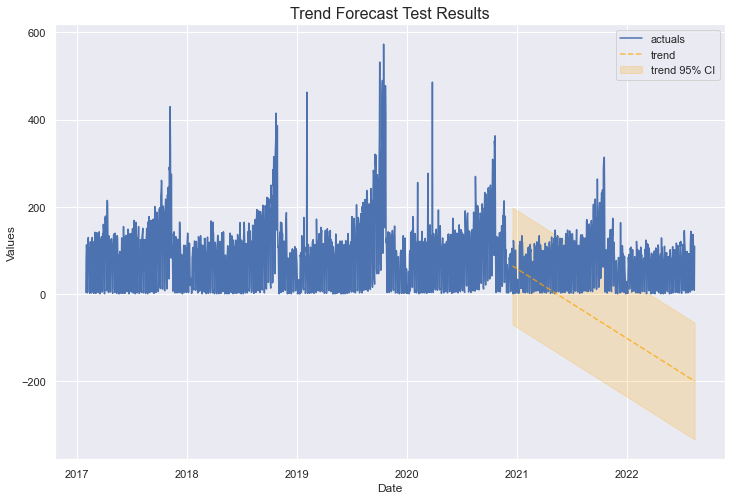

In [25]:
f.plot_test_set(ci=True,models='trend')
plt.title('Trend Forecast Test Results',size=16)
plt.show()

# Trend + Seasonality

In [26]:
f.manual_forecast(trend='add',seasonal='add',call_me='add')

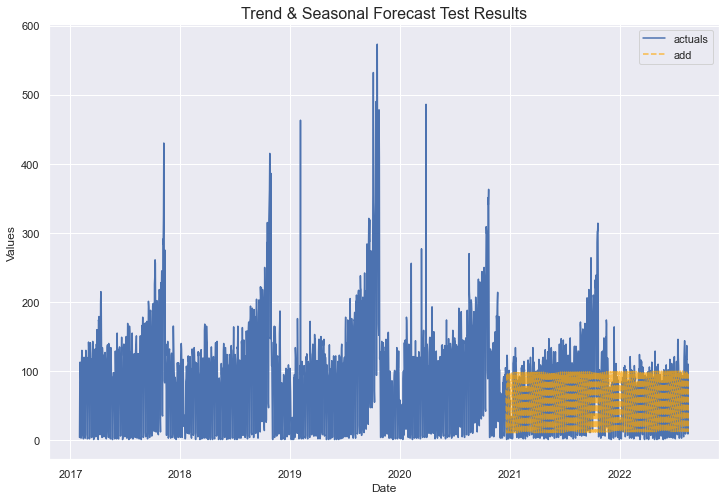

In [28]:
f.plot_test_set(ci=False,models='add')
plt.title('Trend & Seasonal Forecast Test Results',size=16)
plt.show()

# Multiplicative

In [29]:
f.manual_forecast(trend='mul',seasonal='mul',call_me='mul')

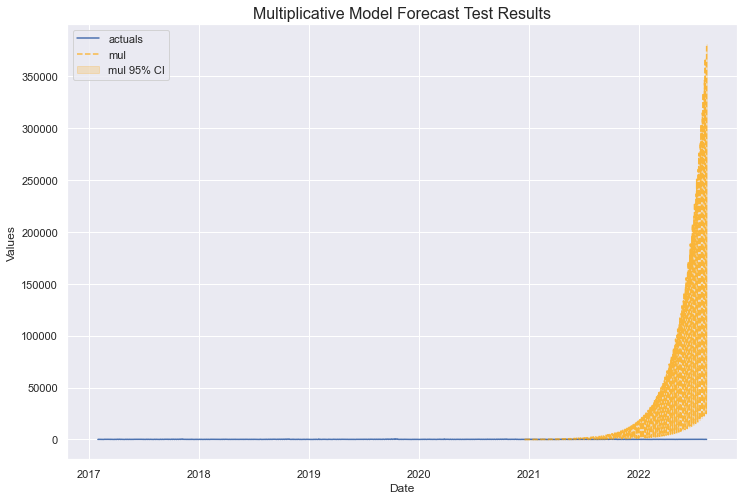

In [30]:
f.plot_test_set(ci=True,models='mul')
plt.title('Multiplicative Model Forecast Test Results',size=16)
plt.show()

# Tuning Model

In [31]:
grid = {
    'trend':['add','mul'],
    'seasonal':['add','mul'],
    'damped_trend':[True,False],
    'initialization_method':[None,'estimated','heuristic']
}

f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me='tuned')

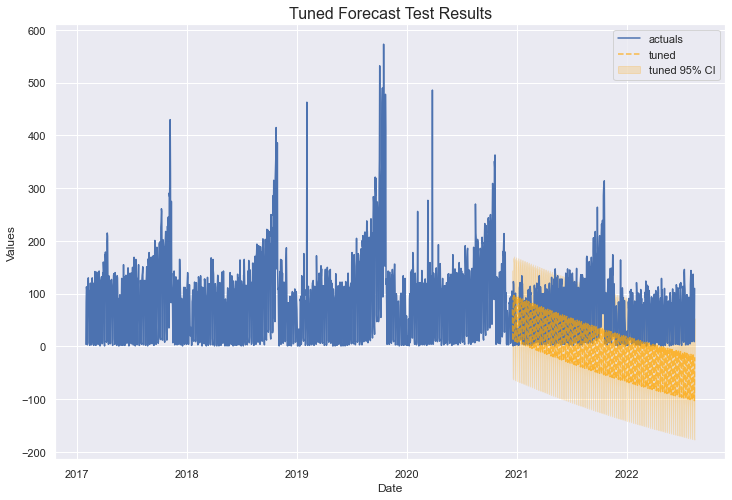

In [32]:
f.plot_test_set(ci=True,models='tuned')
plt.title('Tuned Forecast Test Results',size=16)
plt.show()

In [33]:
f.export_validation_grid('tuned').sort_values('metric_value').head(5)

,trend,seasonal,damped_trend,initialization_method,validation_length,validation_metric,metric_value
15,mul,add,False,None,300,rmse,99.756149
4,add,add,False,estimated,300,rmse,100.866535
5,add,add,False,heuristic,300,rmse,100.866535
17,mul,add,False,heuristic,300,rmse,101.236865
16,mul,add,False,estimated,300,rmse,101.236865


In [34]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = f.export('model_summaries',determine_best_by='TestSetRMSE')
ms[
    [
        'ModelNickname',
        'TestSetMAPE',
        'TestSetR2',
        'InSampleMAPE',
        'InSampleR2',
        'models',
        'best_model'
    ]
]

,ModelNickname,TestSetMAPE,TestSetR2,InSampleMAPE,InSampleR2,models,best_model
0,naive,5.2576,-0.0219,6.5342,0.1714,None,True
1,add,5.5929,-0.4700,2.0231,0.6943,None,False
2,tuned,2.6747,-2.4017,2.1156,0.6860,None,False
3,trend,8.3816,-8.2511,6.4537,0.1608,None,False
4,mul,2246.9448,-1551384.0792,1.7133,0.5062,None,False


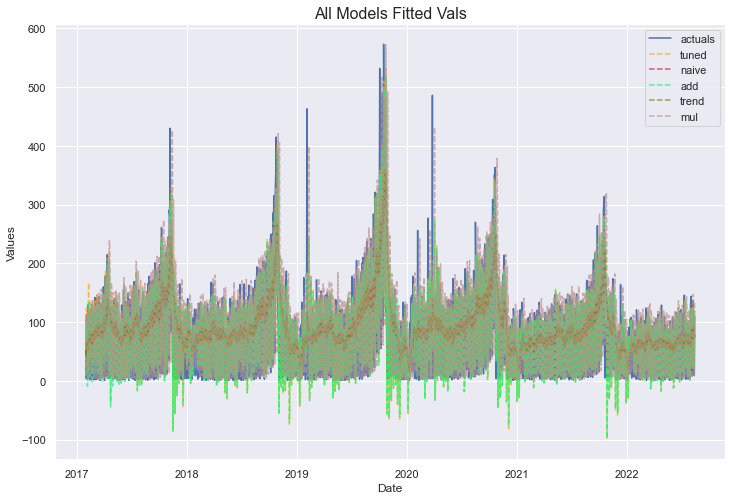

In [35]:
f.plot_fitted(order_by='TestSetMAPE')
plt.title('All Models Fitted Vals',size=16)
plt.show()

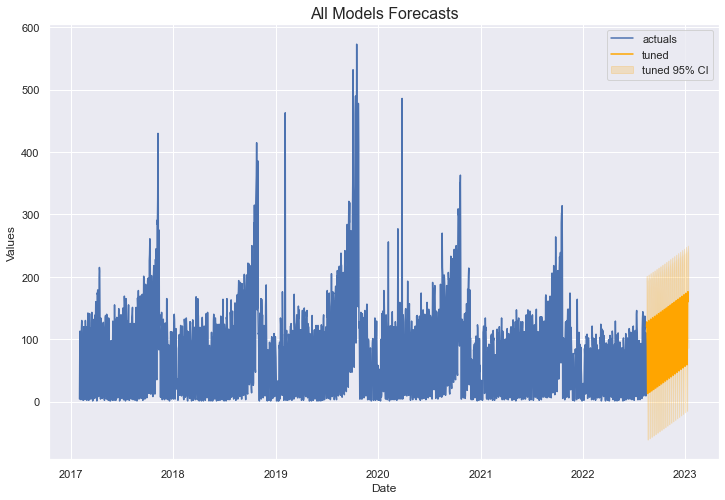

In [36]:
f.plot(ci=True,models='top_1',order_by='TestSetMAPE')
plt.title('All Models Forecasts',size=16)
plt.show()